In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import os


In [18]:
dataset_path = '/content/drive/MyDrive/archive/TrashType_Image_Dataset'


In [19]:
IMG_SIZE = (224, 224)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)


In [21]:
from tensorflow.keras.applications import EfficientNetB0

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)



In [22]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Increased from 128
x = Dropout(0.5)(x)  # Helps prevent overfitting
predictions = Dense(6, activation='softmax')(x)


In [28]:
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/garbage_classifier_model_v2.keras', compile=False)

# Then recompile
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)


In [30]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history=model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 578s 9s/step - accuracy: 0.9785 - loss: 0.1215 - val_accuracy: 0.8191 - val_loss: 0.5484 - learning_rate: 1.0000e-05
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.9855 - loss: 0.0977 - val_accuracy: 0.8211 - val_loss: 0.5409 - learning_rate: 1.0000e-05
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.9940 - loss: 0.0787 - val_accuracy: 0.8290 - val_loss: 0.5312 - learning_rate: 1.0000e-05
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.9905 - loss: 0.0802 - val_accuracy: 0.8171 - val_loss: 0.5548 - learning_rate: 1.0000e-05
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.9930 - loss: 0.0679 - val_accuracy: 0.8330 - val_loss: 0.5294 - learning_rate: 1.0000e-05
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.9941 - loss: 0.0586 - val_accuracy: 0.8350 - val_loss: 0.5213 - learning_rate: 1.0000e-05
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9966 

In [32]:
base_model.trainable = True
# But freeze first 50 layers, and train rest
for layer in base_model.layers[:50]:
    layer.trainable = False


In [33]:
# Save using new format
model.save('/content/drive/MyDrive/garbage_classifier_model_v2.keras')



In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = '/content/drive/MyDrive/archive/TrashType_Image_Dataset'  # Update if needed
IMG_SIZE = (224, 224)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 503 images belonging to 6 classes.


In [35]:
import numpy as np

y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_data.classes



16/16 ━━━━━━━━━━━━━━━━━━━━ 151s 10s/step


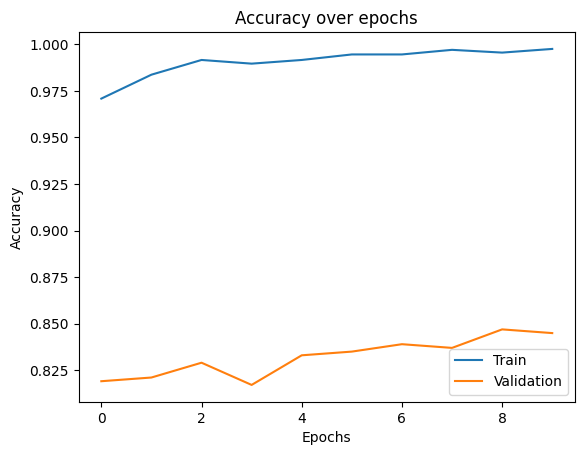

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend()
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


In [39]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


Saved artifact at '/tmp/tmpj1asutvs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140309012901392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140309012902736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140309012903312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140309012903120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140309012901776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140309012901584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140309012903696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140309012904080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140309012904272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140309012902160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140309012898704

In [43]:
# Install Gradio
!pip install -q gradio

#Load your model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

model = keras.models.load_model('/content/drive/MyDrive/garbage_classifier_model_v2.keras', compile=False)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Define class names
class_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# Define prediction function with confidence
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_garbage(img):
    img_resized = img.resize((224, 224))
    img_array = image.img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)[0]
    class_index = np.argmax(predictions)
    confidence = predictions[class_index]

    return {class_names[i]: float(predictions[i]) for i in range(len(class_names))}

# Gradio Interface
import gradio as gr

interface = gr.Interface(
    fn=predict_garbage,
    inputs=gr.Image(type="pil", label="Upload Garbage Image"),
    outputs=gr.Label(num_top_classes=3),
    title="Garbage Classifier",
    description="Upload a garbage image to classify it into cardboard, glass, metal, paper, plastic, or trash."
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4083035b199795df15.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
